Motion Generation
-----------------

Import necessary Python packages. We are using spatialmath's SE3 module for convenient pose representation and manipulation and matplotlib for plotting.

In [1]:
import panda_py
import numpy as np
from matplotlib import pyplot as plt
from spatialmath import SE3

Move the robot to the start position and save the current end-effector pose in `T_0`. The default speed factors have been chosen so that most trajectories will be executed successfully with the default settings. The `Panda` class uses a joint impedance controller to follow the trajectories and you are free to increase the control gains for higher accuracy and speed factors for faster acceleration and velocities. However higher velocities and acceleration may result in libfranka triggering reflexes, this can be avoided by increasing the collision thresholds.

In [2]:
hostname = '172.16.0.2' # Your Panda IP or hostname
panda = panda_py.Panda(hostname)
panda.set_default_behavior() # Panda default collision thresholds
panda.move_to_start()
T_0 = SE3(panda.get_pose(), check=False)
joint_speed_factor = 0.2
cart_speed_factor = 0.2
stiffness = [600, 600, 600, 600, 250, 150, 50]

# Optionally set higher thresholds to execute fast trajectories
panda.get_robot().set_collision_behavior(
    [100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0],
    [100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0],
    [100.0, 100.0, 100.0, 100.0, 100.0, 100.0],
    [100.0, 100.0, 100.0, 100.0, 100.0, 100.0])

Add waypoints relative to the starting pose `T0`, i.e. move 20cm to left with a 45° rotation about x, move 20cm to the right with a rotation of -45° about x and back to the initial pose. These waypoints are executed using the joint and Cartesian motion generators each and the end-effector position log is written to a numpy array. The log uses the libfranka state and as such `O_T_EE` is a list of 16-vectors in column major format and reshaped to 4x4 matrices.

In [3]:
poses = []
poses.append(SE3.Trans(0, 0.2, 0) * T_0 * SE3.Rx(np.pi / 4))
poses.append(SE3.Trans(0, -0.2, 0) * T_0 * SE3.Rx(-np.pi / 4))
poses.append(T_0)

panda.move_to_start()
panda.enable_logging(30000)  # Logging up to 30k samples
panda.move_to_pose(poses, speed_factor=cart_speed_factor, stiffness=stiffness)
log_cart = np.array(panda.get_log()['O_T_EE'])
log_cart = log_cart.reshape((-1, 4, 4)).transpose((0, 2, 1))
panda.disable_logging()

qs = [panda_py.ik(T) for T in poses]

panda.move_to_start()
panda.enable_logging(30000)  # Logging up to 30k samples
panda.move_to_joint_position(qs,
                             speed_factor=joint_speed_factor,
                             stiffness=stiffness)
log_joint = np.array(panda.get_log()['O_T_EE'])
log_joint = log_joint.reshape((-1, 4, 4)).transpose((0, 2, 1))
panda.disable_logging()

Plot the logged end-effector motion in the YZ-plane. Note how the joint motion does not follow a piece-wise linear path between the waypoints in Cartesian space.

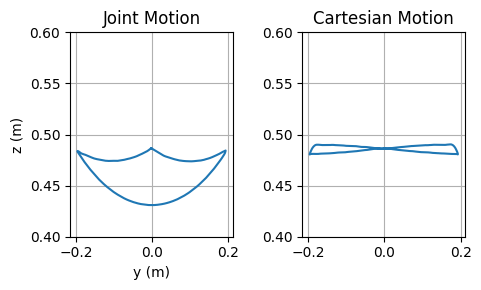

In [4]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(5,3))

ax0.plot(log_joint[:,1,3], log_joint[:,2,3])
ax0.grid(True)
ax0.set_ylim(0.4, 0.6)
ax0.set_title('Joint Motion')
ax0.set_xlabel('y (m)')
ax0.set_ylabel('z (m)')
ax1.plot(log_cart[:,1,3], log_cart[:,2,3])
ax1.grid(True)
ax1.set_ylim(0.4, 0.6)
ax1.set_title('Cartesian Motion')
ax0.set_xlabel('y (m)')
ax0.set_ylabel('z (m)')
fig.tight_layout()